<a href="https://colab.research.google.com/github/kangmg/compchem_with_colab/blob/main/openmm_ase_2d_scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q condacolab
%pip install -q py3Dmol

In [2]:
import condacolab

condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:21
🔁 Restarting kernel...


In [3]:
%%capture
#!mamba install lammps -c conda-forge
!mamba install -c conda-forge openmm
!mamba install openmmtools
!apt install gromacs
!mamba install -c irl -c omnia -c conda-forge narupa-server

In [1]:
#@title Ionic Liquid .pdb % force field file download
#@markdown <font color=skyblue>BMIM EMIM etc.</font> <br>

#@markdown Not all IL supported. Check details below

#@markdown Details : https://github.com/orlandoacevedo/IL/tree/refs/heads/master/0.8*2009IL/ITP
!mkdir -p /content/ff_files
_base_dir = '/content/ff_files'

CATION = "BMIM" # @param ["BMIM","DMIM","EMIM","HMIM","MMIM","OMIM"] {"allow-input":true}

# pdb file
!wget -q https://raw.githubusercontent.com/orlandoacevedo/IL/refs/heads/master/PDB/{CATION}.pdb -O {_base_dir}/{CATION}.pdb

# force field
# cation
!wget -q 'https://github.com/orlandoacevedo/IL/raw/refs/heads/master/0.8*2009IL/ITP/{CATION}_atomtypes_scale0.8.itp' -O {_base_dir}/{CATION}_atomtypes_scale0.8.itp
!wget -q 'https://github.com/orlandoacevedo/IL/raw/refs/heads/master/0.8*2009IL/ITP/{CATION}_scale0.8.itp' -O {_base_dir}/{CATION}_scale0.8.itp

In [4]:
#@title plot utils

from io import StringIO
from ase.build import make_supercell
from ase.io import Trajectory, write, read
import py3Dmol
import numpy as np
import ase
from typing import Union
import os
import matplotlib.pyplot as plt

def atoms2xyz(atoms:ase.Atoms, wrap=True):
    with StringIO() as buffer:
        if wrap:
            atoms.wrap()
        write(buffer, atoms, format='xyz')
        xyz_string = buffer.getvalue()
    return xyz_string


def plot_animation(traj:Union[list[ase.Atoms], str], cell_color='red', background_color='white', copy:bool=False , supercell:np.ndarray=None):
    """
    Visualizes a molecular structure from an XYZ format string along with a cell defined by a 3D array in 3D using py3Dmol.

    Parameters:
        traj (list[ase.Atoms]): list of ASE Atoms object containing the molecular structure.
        cell_color (str): Color of the cell boundary. Default is 'red'.
        background_color (str): Background color of the viewer. Default is 'white'.

    Returns:
        py3Dmol.view: A 3Dmol.js viewer with the structure and cell.
    """
    # read it it is traj path
    if isinstance(traj, str):
        if os.path.exists(traj):
            traj = Trajectory(traj)

    # make supercell
    if copy:
        if not supercell:
            supercell = np.array([
                [2, 0, 0],  # 2*x
                [0, 2, 0],  # 2*y
                [0, 0, 1]   # 1*z
                ])
        else:
            assert supercell.shape == (3,3), 'supercell shape is not (3,3)'
        # copy supercell
        traj = [make_supercell(image, supercell) for image in traj]

    traj_str = ''
    for atoms in traj:
        traj_str += atoms2xyz(atoms)

    if not atoms.cell:
        atoms.cell = np.eye(3) * 0.0001
    cell = atoms.cell

    view = py3Dmol.view()
    view.addModelsAsFrames(traj_str,'xyz')

    # Compute cell boundaries based on the cell array
    origin = [0, 0, 0]
    a, b, c = cell
    vertices = [
        origin,           # (0, 0, 0)
        a,                # a
        b,                # b
        c,                # c
        a + b,            # a + b
        a + c,            # a + c
        b + c,            # b + c
        a + b + c         # a + b + c
    ]

    # Convert vertices to the Py3Dmol format
    vertices = [{'x': v[0], 'y': v[1], 'z': v[2]} for v in vertices]

    # Define edges of the cell
    edges = [
        (0, 1), (0, 2), (0, 3),  # From origin
        (1, 4), (1, 5),          # From a
        (2, 4), (2, 6),          # From b
        (3, 5), (3, 6),          # From c
        (4, 7), (5, 7), (6, 7)   # To the farthest corner
    ]

    # Add lines for each edge
    for start, end in edges:
        view.addLine({
            'start': vertices[start],
            'end': vertices[end],
            'color': cell_color
        })

    # Viewer settings
    view.zoomTo()
    view.animate({'loop': "forward"}) # 'duration' in ms / 'reps': 10 --> 'loop': 'forward'
    view.setBackgroundColor(background_color)
    view.setStyle({'sphere':{'radius': 0.4}, 'stick':{'radius': 0.2}})

    # Show the viewer
    display(view)


def plot_pes(scan_data, angles, x_axis='CCCN', y_axis='CCCC'):
    """
    plot 2d PES

    Parameters
    ----------
    scan_data (2D numpy array):
        2D energy data
    - angles (list or array):
        angles used in scan
    """
    angles = np.array(angles)

    X, Y = np.meshgrid(angles, angles)
    Z = scan_data

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(contour, label='Energy (eV)')
    plt.xlabel(f'{x_axis} Dihedral Angle (degrees)')
    plt.ylabel(f'{y_axis} Dihedral Angle (degrees)')
    plt.axis('square')
    plt.show()

In [5]:
#@title system top writer
from ase.io import read
import os

def write_system_top(name:str, base_dir:str='ff_files'):
    """
    write system topology file

    Parameters
    ----------
    name : str
        molecule name
    base_dir : str
        base directory path contains ff & pdb files
    """
    pdb_res = read(os.path.join(base_dir, f'{name}.pdb')).arrays['residuenames'][0].item()

    top_format = f'''
    ; EMIM_BF4 topology file
;
; Ionic liquid OPLS-AA force field
; Version 3/2017
; Orlando Acevedo
; Email: orlando.acevedo@miami.edu
; Contributors: S.V. Sambasivarao, B. Doherty, X. Zhong, S. Gathiaka, B. Li
;
; S.V. Sambasivarao, O. Acevedo, Development of OPLS-AA Force Field Parameters for 68 Unique Ionic Liquids,
;     J. Chem. Theory Comput., 2009, 5, 1038-1050.
;
; B. Doherty, X. Zhong, S. Gathiaka, B. Li, O. Acevedo, Revisiting OPLS Force Field Parameters for Ionic Liquid Simulations,
;     J. Chem. Theory Comput., 2017, 13, 6131-6145.
;
; Values given below for use in GROMACS 5.0.7 and in comments are traditional OPLS-AA units (e.g., angstroms, kcal/mol, degrees)

#define _FF_OPLS
#define _FF_OPLSAA

[ defaults ]
;nbfunc  comb-rule   gen-pairs   fudgeLJ  fudgeQQ
1         3          yes        0.5      0.5

;;;LOAD atomtypes

#include "{base_dir}/{name}_atomtypes_scale0.8.itp"

;;;LOAD bonded parameters

#include "{base_dir}/{name}_scale0.8.itp"

[ system ]
;name
Neat {pdb_res}

[ molecules]
{pdb_res}  1
'''
    with open('system.top', 'w') as file:
        file.write(top_format)

molecule_name = 'BMIM' # @param {type:"string"}
base_dir = '/content/ff_files' # @param {type:"string"}
write_system_top(molecule_name)

In [6]:
from openmm.app import PDBFile, GromacsTopFile, Simulation
from openmmtools.integrators import DummyIntegrator
import os

pdb_path = os.path.join(base_dir, f'{molecule_name}.pdb')
pdb = PDBFile(pdb_path)

gromacs_top = GromacsTopFile('system.top')

simulation = Simulation(
    topology=gromacs_top.topology,
    system=gromacs_top.createSystem(),
    integrator=DummyIntegrator(),
    )

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [7]:
from narupa.ase.openmm.calculator import OpenMMCalculator
from copy import deepcopy

bmim = read(pdb_path)
bmim_copy = deepcopy(bmim)

calc = OpenMMCalculator(
    simulation=simulation,
    atoms=bmim
)

bmim.calc = calc

Scanning PES: 100%|██████████| 1369/1369 [00:02<00:00, 595.50it/s]


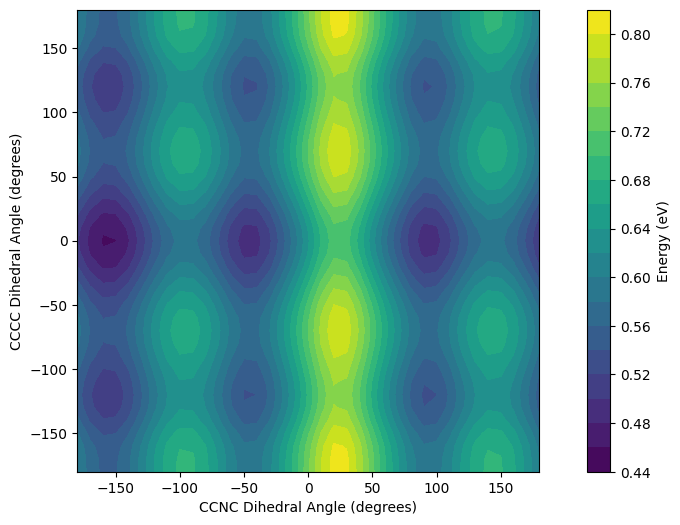

In [ ]:
#@title openmm ff

# 2D dihedral scan

import numpy as np
from ase.io import read
from tqdm import tqdm


angles = range(-180, 181, 10)
total_steps = len(angles) * len(angles)
frames = []
scan_data = np.zeros((len(angles), len(angles)))

with tqdm(total=total_steps, desc="Scanning PES") as pbar:
    for idx_cccn, angle_cccn in enumerate(angles):
        # cccn rotation
        mask_cccn = np.array([False] * len(bmim))
        dihedral_indices_cccn = [15, 12,  0, 2]
        rotation_indices_cccn = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
        mask_cccn[rotation_indices_cccn] = True

        # rotate cccn dihedral angles
        _atoms = deepcopy(bmim_copy)
        _atoms.set_dihedral(*dihedral_indices_cccn, angle_cccn, mask=mask_cccn)

        for idx_cccc, angle_cccc in enumerate(angles):
            # cccc rotation
            mask_cccc = np.array([False] * len(bmim))
            dihedral_indices_cccc = [22, 18, 15, 12]
            rotation_indices_cccc = [18, 19, 20, 21, 22, 23, 24]
            mask_cccc[rotation_indices_cccc] = True

            # rotate cccc dihedral angles
            _atoms_ = deepcopy(_atoms)
            _atoms_.set_dihedral(*dihedral_indices_cccc, angle_cccc, mask=mask_cccc)
            frames.append(_atoms_)

            # scan data
            scan_data[idx_cccn, idx_cccc] = calc.get_potential_energy(atoms=_atoms_)

            # tqdm progress update
            pbar.update(1)

# save array
ff_scan_data = deepcopy(scan_data)
np.save('openmm_ff.npy', ff_scan_data)

plot_pes(ff_scan_data, angles, x_axis='CCNC', y_axis='CCCC')

In [ ]:
plot_animation(frames)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.